In [1]:
%matplotlib inline

import urllib.request
import io
import zipfile

from pathlib import Path
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

import igraph as ig

from itertools import combinations

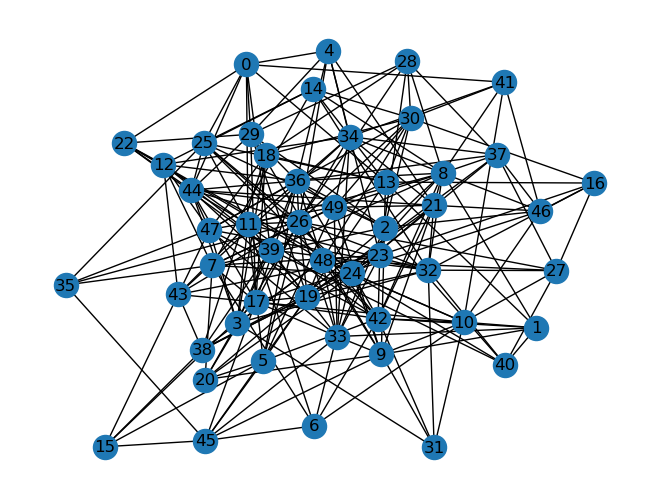

In [2]:
#instance

#inst_="karate"
#G = nx.karate_club_graph()
#nx.draw_networkx_labels(G,pos=nx.spring_layout(G))

#inst_="sudoku"
#G = nx.sudoku_graph(50)

#inst_="random_tree"
#G = nx.random_tree(50)

#inst_="random_internet"
#dim=100
#G = nx.random_internet_as_graph(dim)

# erdos_renyi_graph(n, p, seed=None, directed=False)
#G = nx.erdos_renyi_graph(50,0.1)

# barabasi_albert_graph(n, m, seed=None, initial_graph=None)
#G = nx.barabasi_albert_graph()


#print("Node Degree")
#for v in G:
#    print(f"{v:4} {G.degree(v):6}")
#print(G)

inst_="erdos"
GI = ig.Graph.Erdos_Renyi(n=50, p=0.2, directed=False, loops=False)
A = ig.Graph.get_edgelist(GI)
#G = nx.DiGraph(A)
G = nx.Graph(A)
#G = ig.Graph.to_networkx(GI)
#ig.plot(GI)

nx.draw(G,  with_labels = True)



In [4]:
nx.is_connected(G)

True

In [3]:
def is_subclique(G, nodelist):
    '''
    For each pair of nodes in nodelist whether there is an edge 
    if any edge is missing, we know that it's not a subclique.
    if all edges are there, it is a subclique
    '''
    for (u,v) in combinations(nodelist,2):  #check each possible pair
        if not G.has_edge(u,v):
            return False #if any edge is missing we're done
    return True  #if we get to here, then every edge was there.  It's True.

In [4]:
N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

dm = np.zeros((N,N), dtype=int)

p = nx.shortest_path(G)

for i in range(0,N):
    for j in range(0,N):
        dm[i][j] = len(p[i][j])-1

#G.edges


In [5]:
for i in G:
    Ni = nx.neighbors(G,i)

    nodelist = []
    for k in Ni:
        nodelist.append(k)
    
    if(is_subclique(G, nodelist)):
        print("vizinhanca de %d" %i)


In [6]:
# form1
form_="form1"
method_="lp"

N = nx.number_of_nodes(G)
M = nx.number_of_edges(G)

lb = np.zeros((N), dtype=float)
ub = np.zeros((N), dtype=float)
time = np.zeros((N), dtype=float)
gap = np.zeros((N), dtype=float)
nodes = np.zeros((N), dtype=float)
status = np.zeros((N), dtype=float)

RESULT_PATH   = Path('../result/')

for i in G:

    Ni = nx.neighbors(G,i)

    lista = []
    for k in Ni:
        lista.append(k)
    
    if(is_subclique(G, lista)):
        #print("tukey[%d] = 1" %i)
        lb[i] = 1
        ub[i] = 1
        gap[i] = 0.0
        time[i] = 0.0
        nodes[i] = 0
        status[i] = 1
    else:

        model = gp.Model(f"{method_}_{inst_}_{form_}")

        # configurando parametros
        # model.Params.TimeLimit = 60
        model.Params.MIPGap = 1.e-6
        model.Params.Threads = 1
        # model.Params.Presolve = 0
        # model.Params.Cuts = 0

        if (method_=="mip"):
            x = model.addVars(N, vtype=GRB.BINARY, name="x")
        else:
            x = model.addVars(N, lb=0.0, ub=1.0, vtype=GRB.CONTINUOUS, name="x")

        l = list(tuple())
        for u in range(0, N):
            for w in range(u+1, N):
                l.append((u,w))

        y = model.addVars(l, vtype=GRB.CONTINUOUS, name='y')
#        y = model.addVars(l, vtype=GRB.BINARY, name='y')
   
        obj = 0
        for j in G:
            obj += 1 * x[j]
         
        model.setObjective(obj, GRB.MAXIMIZE)
     
        # Turn off display and heuristics
        gp.setParam('OutputFlag', 0)
        gp.setParam('Heuristics', 0)

        constr = 0
        constr += 1 * x[i]
        model.addConstr(constr == 0)

        for u in range(0,N):
            Nu = nx.neighbors(G,u)
            for w in range(u+1,N):
                #if dm[u,w] <= N:
                for s in range(0,N):
                #for s in Nu:
                    if (s != u) and (s != w):
                        if (dm[u,s] + dm[s,w] == dm[u,w]):
                            model.addConstr(x[u] + x[w] <= 1 + x[s])

        # maximal independent set constraints
        for u in range(0,N):
            if (u == i):
                Im = nx.maximal_independent_set(G, [i])
                constr = 0
                for k in Im:
                    constr = 1 * x[k]
                model.addConstr(constr <= 1)
            else:
                Im = nx.maximal_independent_set(G, [u])
                constr = 0
                for k in Im:
                    constr = 1 * x[k]
                model.addConstr(constr <= 1 + (len(Im)- 1)*x[u])

        # rlt constraint
        for u in range(0,N):
            for w in range(u+1,N):
                if (u,w) in G.edges:
                    model.addConstr(y[u,w] <= x[u])
                    model.addConstr(y[u,w] <= x[w])
                    model.addConstr(x[u] + x[w] <= 1 + y[u,w])

        #x[i].Start = 0.0
        #relax = model.relax()
        #relax.optimize()

        #model.write(f"{method_}_{inst_}_{form_}.lp")

        model.optimize()

        tmp = 0
        if model.status == GRB.OPTIMAL:
            tmp = 1
    
        if (method_=="mip"):
            lb[i] = N - model.objBound
            ub[i] = N - model.objVal
            gap[i] = model.MIPGap
            time[i] = model.Runtime
            nodes[i] = model.NodeCount
            status[i] = tmp
        else:
            ub[i] = N - model.objVal
            time[i] = model.Runtime
            status[i] = tmp

    if (method_=="mip"):
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(lb[i],1))+';'
            +str(round(ub[i],1))+';'
            +str(round(gap[i],2))+';'
            +str(round(time[i],2))+';'
            +str(round(nodes[i],1))+';'
            +str(round(status[i],1))+'\n')
        arquivo.close()
    else:
        arquivo = open(os.path.join(RESULT_PATH,f"{method_}_tukey_{inst_}_{form_}.txt"),'a')
        tmp = i
        arquivo.write(
            str(tmp)+';'
            +str(round(ub[i],1))+';'
            +str(round(time[i],2))+';'
            +str(round(status[i],1))+'\n')
        arquivo.close()

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-15
Set parameter MIPGap to value 1e-06
Set parameter Threads to value 1


In [28]:
#t = 0
#for i in ub:
#    print("tukey[%d] =" %t, end=" ")
#    print("%g" %i)
#    t = t+1

In [23]:
if method_ == "lp":
    for i in G:
        print("node:%d, ub: %2f, time: %2f " % (i, ub[i], time[i]))

if method_ == "mip":
    for i in G:
        print("node:%d, lb: %2f, ub: %2f, gap: %2f, time: %2f, nodes: %2f, status: %2f " % (i, lb[i], ub[i], gap[i], time[i], nodes[i], status[i]))
    #    status[i] = 1

node:0, ub: 19.500000, time: 0.016070 
node:4, ub: 18.250000, time: 0.014152 
node:2, ub: 20.500000, time: 0.015695 
node:7, ub: 20.666667, time: 0.014255 
node:6, ub: 18.000000, time: 0.014520 
node:1, ub: 18.750000, time: 0.017582 
node:8, ub: 22.333333, time: 0.018694 
node:9, ub: 21.000000, time: 0.013080 
node:10, ub: 20.600000, time: 0.014272 
node:11, ub: 21.000000, time: 0.015395 
node:3, ub: 19.750000, time: 0.015652 
node:5, ub: 18.750000, time: 0.014386 
node:12, ub: 19.656250, time: 0.017432 
node:13, ub: 20.666667, time: 0.013215 
node:14, ub: 19.000000, time: 0.016946 
node:15, ub: 16.250000, time: 0.014772 
node:16, ub: 18.333333, time: 0.014157 
node:17, ub: 21.000000, time: 0.014846 
node:18, ub: 19.272727, time: 0.015665 
node:19, ub: 20.666667, time: 0.014293 
node:20, ub: 18.714286, time: 0.016659 
node:21, ub: 20.615385, time: 0.016372 
node:22, ub: 18.000000, time: 0.014481 
node:23, ub: 20.000000, time: 0.016504 
node:24, ub: 21.333333, time: 0.016277 
node:25, u